# Training feature selection

## Background

We started with extracting as many EO measurements as that can be feasibly calculated from the growing season of interest. However, some of these measurements may be correlated because they describe similar or related properties of the crops.
A good practice is to remove the highly correlated features because they increase the complexity of a model without enhancing its prediction performance.

Another common issue with labelled training data is class imbalance, i.e. it has skewed class proportions. During model training, the algorithm will optimize over all training data, hence imbalanced training data may lead to a biased model. For example, the model is more likely to mis-classify a minority class as a majority class than the other way around.

In some cases, distribution of the training data is designed to match the true distribution of the classes, and the prediction is expected to bias against an infrequent class. In some other cases, accuray requirements are different for different classes. It is then desirable to adjust the porportions of the training labels to include more points for classes where commission error is preferred over omission error.

## Description

This notebook demonstrates how to explore class imbalance and correlations between the features extracted in the [feature extracion notebook](3_Training_feature_extraction.ipynb), and adjust the data before using it to train a model.


## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [16]:
%matplotlib inline

import json
import os
from collections import Counter
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from odc.io.cgroups import get_cpu_quota

## Load training data and label dictionary

We will load the training data saved from the [feature extracion notebook](3_Training_feature_extraction.ipynb), along with the mapping between crop labels and the numerical classes.

In [17]:
model_basepath = "Results/Model"
if not os.path.exists(model_basepath):
    os.makedirs(model_basepath)
    
# Training data file from previous step
data_path = os.path.join(model_basepath,"single_crops_merged_training_features_2022_all.csv")

# Dictionary with class labels from previous step
labels_path = os.path.join(model_basepath,"class_labels.json")

### Inspect the label and feature columns

As shown below, we have over 100 features extracted.

In [18]:
# load the data
model_input_df = pd.read_csv(data_path)
label_col = model_input_df.columns[0]
feature_cols = model_input_df.columns[1:]

print(f"Label column:\n{label_col}\n")
print(f"Feature columns:\n{feature_cols}\n")
print('number of features: ',len(feature_cols))

Label column:
label

Feature columns:
Index(['blue_s2_semiannual_2021_07', 'green_s2_semiannual_2021_07',
       'red_s2_semiannual_2021_07', 'nir_1_s2_semiannual_2021_07',
       'nir_2_s2_semiannual_2021_07', 'swir_1_s2_semiannual_2021_07',
       'swir_2_s2_semiannual_2021_07', 'red_edge_1_s2_semiannual_2021_07',
       'red_edge_2_s2_semiannual_2021_07', 'red_edge_3_s2_semiannual_2021_07',
       'smad_s2_semiannual_2021_07', 'emad_s2_semiannual_2021_07',
       'bcmad_s2_semiannual_2021_07', 'NDVI_s2_semiannual_2021_07',
       'LAI_s2_semiannual_2021_07', 'SAVI_s2_semiannual_2021_07',
       'MSAVI_s2_semiannual_2021_07', 'MNDWI_s2_semiannual_2021_07',
       'blue_s2_semiannual_2022_01', 'green_s2_semiannual_2022_01',
       'red_s2_semiannual_2022_01', 'nir_1_s2_semiannual_2022_01',
       'nir_2_s2_semiannual_2022_01', 'swir_1_s2_semiannual_2022_01',
       'swir_2_s2_semiannual_2022_01', 'red_edge_1_s2_semiannual_2022_01',
       'red_edge_2_s2_semiannual_2022_01', 'red_edge_

In [19]:
# Read the class label dictionary
with open(labels_path, "r") as json_file:
    labels_dict = json.load(json_file)

In [20]:
labels_dict

{'Maize': 0, 'Others': 1, 'Sesame': 2, 'Soy': 3}

## Class rebalancing

We first inspect the number of samples per class and notice we have significant larger number of "Others" class than the single crop classes.

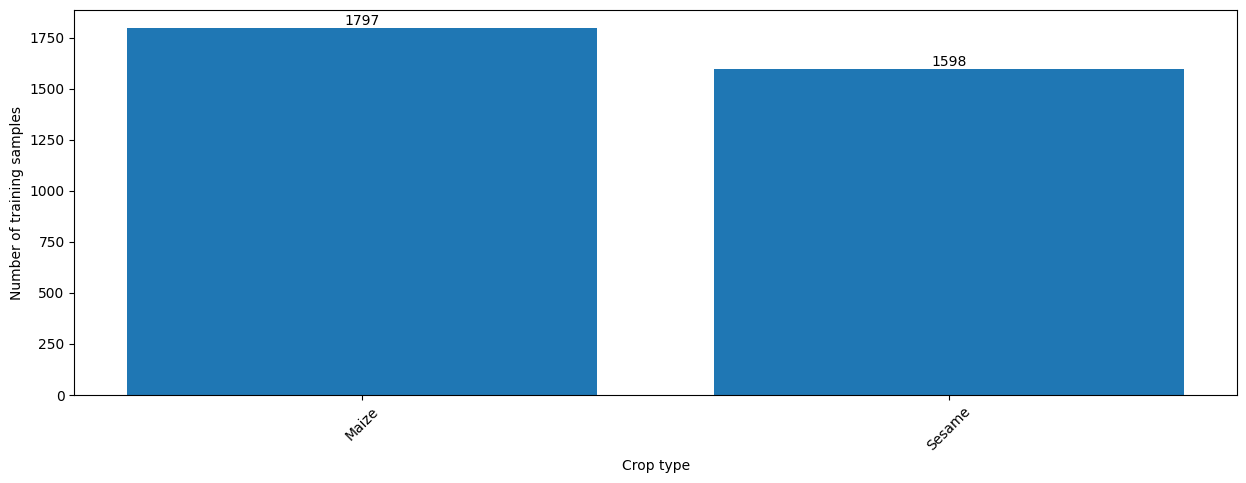

In [21]:
# Investigate value counts for each class
class_counts=model_input_df[label_col].value_counts()
class_indices=class_counts.index
labels_dict_inv={value: key for key, value in labels_dict.items()}
class_legends=[labels_dict_inv[class_indices[i]] for i in range(len(class_indices))]
plt.figure(figsize=(15,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of training samples')
plt.gca().set_xlabel('Crop type')
plt.gca().tick_params(axis='x', rotation=45)

We then reduce the number of samples for classes with significantly larger sample size than the other classes. In this case, we will allow sample size within 10 times the smallest sample.

> We are not making all sample sizes same because we want to preserve the large number of Maize, Sesame and Others samples to capture intra-class diversity. 

In [22]:
min_count = class_counts.values.min()
for i in range(len(class_counts)):
    if class_counts.values[i]>10*min_count:
        n_samples_dropped=class_counts.values[i]-10*min_count
        print('dropping {} of {} samples'.format(n_samples_dropped,labels_dict_inv[class_indices[i]]))
        model_input_df.drop(model_input_df[model_input_df[label_col]==class_indices[i]].sample(n=n_samples_dropped).index,
                            axis=0,inplace=True)
    else:
        print('no balancing needed')

no balancing needed
no balancing needed


### Check the sample sizes again

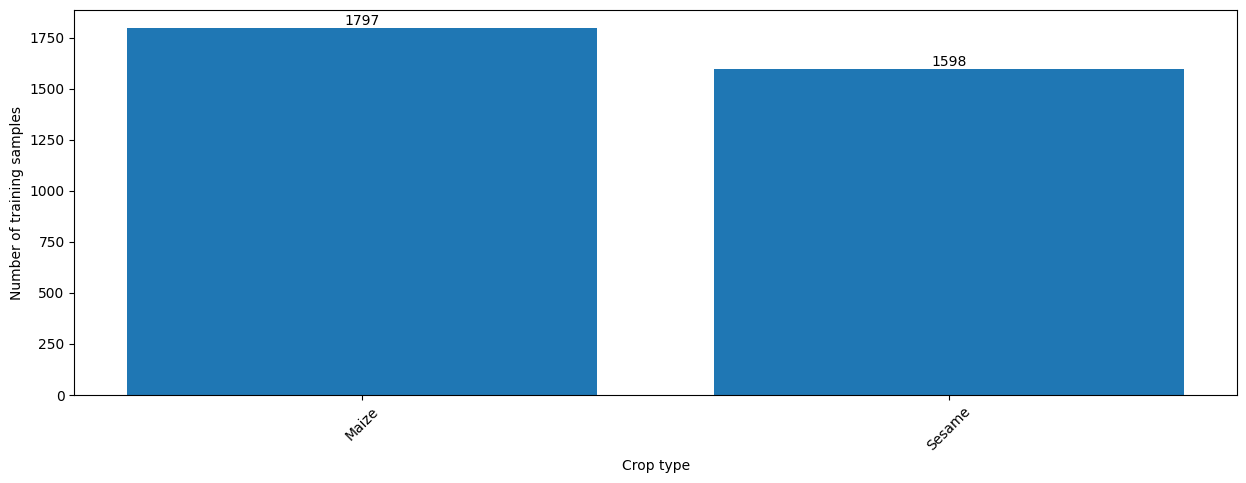

In [23]:
# Investigate value counts for each class
class_counts=model_input_df[label_col].value_counts()
class_indices=class_counts.index
labels_dict_inv={value: key for key, value in labels_dict.items()}
class_legends=[labels_dict_inv[class_indices[i]] for i in range(len(class_indices))]
plt.figure(figsize=(15,5))
ax=plt.bar(class_legends,height=class_counts.to_numpy())
plt.bar_label(ax)
plt.gca().set_ylabel('Number of training samples')
plt.gca().set_xlabel('Crop type')
plt.gca().tick_params(axis='x', rotation=45)

## Drop correlated features

To inspect the feature correlations, we will split the data into features and labels.

In [24]:
# split into features and labels
X = model_input_df.drop(label_col, axis=1).values
y = model_input_df[[label_col]].values.ravel()

### Create and visualize the correlation_matrix

In [25]:
X_ = model_input_df.drop(label_col, axis=1)
correlation_matrix = X_.corr().abs()

The correlations can be visualized in a color-coded table. The coefficient values range from 0 to 1, with 0 for no corelation and 1 for perfect correlation. The diagonal elements are always 1.

> As shown below, some measurements are highly correlated, with corelation coefficient values close to 1.

In [26]:
# plot correlation matrix
correlation_matrix.style.background_gradient(cmap='coolwarm').format(precision=2)

,blue_s2_semiannual_2021_07,green_s2_semiannual_2021_07,red_s2_semiannual_2021_07,nir_1_s2_semiannual_2021_07,nir_2_s2_semiannual_2021_07,swir_1_s2_semiannual_2021_07,swir_2_s2_semiannual_2021_07,red_edge_1_s2_semiannual_2021_07,red_edge_2_s2_semiannual_2021_07,red_edge_3_s2_semiannual_2021_07,smad_s2_semiannual_2021_07,emad_s2_semiannual_2021_07,bcmad_s2_semiannual_2021_07,NDVI_s2_semiannual_2021_07,LAI_s2_semiannual_2021_07,SAVI_s2_semiannual_2021_07,MSAVI_s2_semiannual_2021_07,MNDWI_s2_semiannual_2021_07,blue_s2_semiannual_2022_01,green_s2_semiannual_2022_01,red_s2_semiannual_2022_01,nir_1_s2_semiannual_2022_01,nir_2_s2_semiannual_2022_01,swir_1_s2_semiannual_2022_01,swir_2_s2_semiannual_2022_01,red_edge_1_s2_semiannual_2022_01,red_edge_2_s2_semiannual_2022_01,red_edge_3_s2_semiannual_2022_01,smad_s2_semiannual_2022_01,emad_s2_semiannual_2022_01,bcmad_s2_semiannual_2022_01,NDVI_s2_semiannual_2022_01,LAI_s2_semiannual_2022_01,SAVI_s2_semiannual_2022_01,MSAVI_s2_semiannual_2022_01,MNDWI_s2_semiannual_2022_01,ndvi_mean_0,ndvi_mean_1,ndvi_mean_2,ndvi_mean_3,ndvi_mean_4,ndvi_mean_5,ndvi_mean_6,ndvi_mean_7,ndvi_mean_8,ndvi_mean_9,ndvi_mean_10,ndvi_mean_11,bs_mean_Q4_2021,pv_mean_Q4_2021,npv_mean_Q4_2021,ue_mean_Q4_2021,bs_mean_Q1_2022,pv_mean_Q1_2022,npv_mean_Q1_2022,ue_mean_Q1_2022,bs_mean_Q2_2022,pv_mean_Q2_2022,npv_mean_Q2_2022,ue_mean_Q2_2022,bs_mean_Q3_2022,pv_mean_Q3_2022,npv_mean_Q3_2022,ue_mean_Q3_2022,slope
blue_s2_semiannual_2021_07,1.00,0.92,0.59,0.46,0.46,0.67,0.61,0.71,0.46,0.44,0.11,0.46,0.37,0.23,0.29,0.28,0.27,0.33,0.35,0.45,0.19,0.20,0.20,0.57,0.43,0.41,0.23,0.20,0.24,0.10,0.08,0.11,0.18,0.16,0.14,0.01,0.27,0.41,0.30,0.05,0.51,0.42,0.05,0.27,0.33,0.32,0.41,0.44,0.27,0.17,0.52,0.62,0.05,0.02,0.04,0.07,0.01,0.18,0.34,0.17,0.50,0.27,0.52,0.52,0.01
green_s2_semiannual_2021_07,0.92,1.00,0.56,0.73,0.72,0.79,0.68,0.90,0.73,0.71,0.17,0.55,0.38,0.47,0.54,0.54,0.53,0.47,0.28,0.52,0.12,0.44,0.44,0.64,0.35,0.52,0.45,0.43,0.40,0.04,0.27,0.29,0.39,0.38,0.37,0.02,0.51,0.60,0.52,0.13,0.34,0.30,0.20,0.43,0.50,0.51,0.59,0.62,0.13,0.43,0.64,0.73,0.20,0.08,0.18,0.11,0.14,0.35,0.50,0.15,0.35,0.49,0.68,0.45,0.13
red_s2_semiannual_2021_07,0.59,0.56,1.00,0.02,0.02,0.48,0.67,0.58,0.05,0.02,0.28,0.05,0.19,0.35,0.29,0.27,0.28,0.28,0.07,0.08,0.12,0.05,0.05,0.30,0.36,0.09,0.05,0.04,0.14,0.04,0.07,0.05,0.06,0.05,0.06,0.44,0.29,0.22,0.08,0.33,0.42,0.21,0.04,0.19,0.12,0.10,0.08,0.05,0.33,0.27,0.07,0.28,0.25,0.19,0.06,0.05,0.17,0.06,0.07,0.09,0.18,0.02,0.08,0.18,0.45
nir_1_s2_semiannual_2021_07,0.46,0.73,0.02,1.00,0.99,0.75,0.48,0.81,0.99,0.99,0.48,0.75,0.59,0.92,0.95,0.96,0.95,0.62,0.15,0.60,0.06,0.78,0.78,0.61,0.11,0.67,0.77,0.77,0.55,0.19,0.48,0.57,0.72,0.70,0.70,0.14,0.90,0.85,0.75,0.37,0.10,0.08,0.38,0.62,0.71,0.74,0.80,0.82,0.08,0.77,0.79,0.76,0.35,0.30,0.55,0.39,0.40,0.60,0.71,0.25,0.13,0.76,0.85,0.42,0.11
nir_2_s2_semiannual_2021_07,0.46,0.72,0.02,0.99,1.00,0.76,0.50,0.81,1.00,1.00,0.49,0.76,0.60,0.92,0.95,0.95,0.95,0.65,0.15,0.61,0.06,0.79,0.80,0.63,0.11,0.68,0.79,0.79,0.55,0.19,0.48,0.58,0.73,0.72,0.72,0.13,0.91,0.86,0.76,0.37,0.10,0.08,0.39,0.63,0.73,0.75,0.81,0.84,0.08,0.78,0.79,0.78,0.36,0.30,0.56,0.40,0.41,0.62,0.72,0.25,0.13,0.78,0.87,0.42,0.11
swir_1_s2_semiannual_2021_07,0.67,0.79,0.48,0.75,0.76,1.00,0.93,0.89,0.77,0.76,0.26,0.65,0.47,0.56,0.57,0.59,0.58,0.91,0.10,0.45,0.12,0.68,0.69,0.73,0.26,0.51,0.69,0.69,0.51,0.12,0.41,0.58,0.66,0.65,0.65,0.20,0.58,0.58,0.52,0.11,0.24,0.31,0.32,0.75,0.80,0.79,0.84,0.82,0.25,0.41,0.74,0.93,0.51,0.06,0.41,0.40,0.33,0.60,0.76,0.19,0.26,0.75,0.87,0.25,0.35
swir_2_s2_semiannual_2021_07,0.61,0.68,0.67,0.48,0.50,0.93,1.00,0.79,0.52,0.50,0.03,0.41,0.24,0.24,0.26,0.28,0.27,0.86,0.06,0.25,0.10,0.49,0.51,0.66,0.32,0.30,0.50,0.50,0.43,0.11,0.34,0.45,0.49,0.49,0.48,0.39,0.29,0.29,0.31,0.02,0.32,0.35,0.19,0.67,0.67,0.66,0.68,0.65,0.35,0.15,0.57,0.79,0.56,0.07,0.31,0.40,0.17,0.42,0.61,0.12,0.23,0.59,0.69,0.03,0.46
red_edge_1_s2_semiannual_2021_07,0.71,0.90,0.58,0.81,0.81,0.89,0.79,1.00,0.83,0.81,0.21,0.56,

We will define a function and set a threshold of 0.9 to remove correlated features.

In [27]:
removal_threshold = 0.9

In [28]:
# function for removing correlated variables
def DropCorrelatedFeatures(X_, removal_threshold=0.9):
    to_drop = set()  # set of features to drop
    correlation_matrix = X_.corr().abs()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if (correlation_matrix.iloc[i, j] >= removal_threshold) and (correlation_matrix.columns[j] not in to_drop):
                colname = correlation_matrix.columns[i]
                to_drop.add(colname)
    to_drop = list(to_drop)
    X_dropped = X_.copy()
    X_dropped = X_dropped.drop(to_drop, axis=1)
    return X_dropped

In [29]:
X_ = model_input_df.drop(label_col, axis=1)
X_dropped = DropCorrelatedFeatures(X_, removal_threshold=removal_threshold)
print("# of features kept:", len(X_dropped.columns))

# of features kept: 38


## Save the selected features

In [30]:
output_features = pd.concat([model_input_df[label_col], X_dropped], axis = 1)

output_filename = os.path.join(model_basepath, "single_crops_merged_training_features_2022_selected.csv")
output_features.to_csv(output_filename, index=False)